# HW3: The Centralized Curator Model

### Bhaven Patel
### 4/2/2019

I worked with Anthony Rentsch, Lipika Ramaswamy, and Karina Huang on this homework.

My code can be found on my [Github](https://github.com/bhavenp/cs208/blob/master/homework/HW3/HW3_Bhaven_Patel.ipynb).

## Problem 1: Tails, Trimming, and Winsorization

**(a)**<br>

$$
M(x)=\dfrac{1}{0.9n}\left(\sum_{P_0.05 \leq x_i \leq P_0.95} x_i\right) + Lap\left( \dfrac{D}{0.9n\epsilon} \right)
$$

This implementation of the Trimmed mean is $\epsilon$-DP if the trimming transformation $T$ on $x$ ($x$ is trimmed from its 5th to its 95th percentile) is c-Lipschitz with $c=1$ and the mechanism $M$ is $\epsilon$-DP.

First, we can show that the trimming transformation $T$ on $x$ is c-Lipschitz with $c=1$:<br>
Begin with $x$ and $x'$, which hold $n$=20 values each in the range [0,...,D]
$$
x = [x_1, ..., x_{20}]\\
x' = [x_2, ..., x_{21}]\\
$$

The trimming transformation $T$ applied to $x$ and $x'$ would result in
$$
T(x) = [x_2, ..., x_{19}]\\
T(x') = [x_3, ..., x_{20}]\\
$$

$T(x)$ is $c$-Lipschitz if $\forall x,x' \;\; d(T(x), T(x')) \leq c\cdot d(x, x')$, where $d(x, x')$ denotes the distance between datasets $x$ and $x'$ defined by the number of rows you would need to change in $x'$ to make it the same as $x$. In this case, $d(x, x') = 1$ and $d(T(x), T(x')) = 1$, so $c=1$. Thus, $T(x)$ is $c$-Lipschitz with $c=1$. This would hold for any value of $n$.

A mechanism $M$ is $\epsilon$-DP when adding Laplace noise sampled from $Lap\left(\dfrac{GS}{\epsilon}\right)$, where $GS$ is the global sensitivity. In our case, the $GS = \dfrac{D}{0.9n}$ and we are adding $Lap\left(\dfrac{D}{0.9n\epsilon}\right)$ noise, so our mechanism is $\epsilon$-DP. From the lemma in class, since $M$ is $\epsilon$-DP and $T$ is $1$-Lipschitz, then $M\circ T$ is $1 \cdot \epsilon$-DP. Thus, this Trimmed mean algorithm is $\epsilon$-DP.


The code for the implementation is below.

In [1]:
rm(list=ls())		# Remove any objects in memory

#### Parameters ####

# Random draw from Laplace distribution
#
# mu numeric, center of the distribution
# b numeric, spread
# size integer, number of draws
# 
# return Random draws from Laplace distribution
# example:
# 
# rlap(size=1000)

rlap = function(mu=0, b=1, size=1) {
    p <- runif(size) - 0.5
    draws <- mu - b * sgn(p) * log(1 - 2 * abs(p))
    return(draws)
}

# Sign function
# 
# Function to determine what the sign of the passed values should be.
#
# x numeric, value or vector or values
# return The sign of passed values
# example:
#
# sgn(rnorm(10))


sgn <- function(x) {
    return(ifelse(x < 0, -1, 1))
}


## Bound/Censor/Clip a variable to a range
clip <- function(x, lower, upper){
	x.clipped <- x
	x.clipped[x.clipped<lower] <- lower
	x.clipped[x.clipped>upper] <- upper
	return(x.clipped)	
}

## Post-process a vector or matrix of DP count releases, into probabilities
normalize <- function(x){
	x[x<0] <- 0
	x <- x/sum(x)
	return(x)
}

In [83]:
# Generate a dataset of size
#
# max_value- maximum value any element in the dataset should take on
# size- number of elements to include in dataset
# 
# returns a differentially private mean release from the trimmed data

create_dataset = function(max_value, size){
    return(sample(0:max_value, size = size, replace = TRUE));
}

In [3]:
# Trimmed mean function for releasing a DP mean from data trimmed to its 5% to 95% intervals
#
# x- numeric vector of values
# max_value- maximum value any element in 'x' may take
# epsilon- privacy loss parameter
# 
# returns a differentially private mean release from the trimmed data

trimmed_mean = function(x, max_value, epsilon){
    n <- length(x); #get number of elements in x
    #get 5% and 95% cutoff values
    cutoffs <- quantile(x, probs = c(0.05, 0.95) )
    lower = cutoffs[1];
    upper = cutoffs[2];
    x.trimmed <- x[x >= lower & x <= upper]; #trim x
    
    sensitivity <- max_value/ (0.9*n);
    scale <- sensitivity / epsilon; #scale for Laplace noise

    sensitiveValue <- mean(x.trimmed)
    DPrelease <- sensitiveValue + rlap(mu=0, b=scale, size=1)

    return(list(release=DPrelease, true=sensitiveValue));
}

## Post-process a vector or matrix of DP count releases, into probabilities
normalize <- function(x){
	x[x<0] <- 0
	x <- x/sum(x)
	return(x)
}

In [4]:
max_value = 10;
size = 20;

test <- create_dataset(max_value, size);
print(test)

trimmed_mean(test, max_value = max_value, epsilon = 0.4)

 [1]  1  7  3  7  9  5  9  5  7  9  3  4  4  1  2  4  8  6 10  8


$release
[1] 6.440918

$true
[1] 5.368421

<hr>

**(b)**<br>

$$
M(x)=\dfrac{1}{n}\sum_{i=1}^n [x_i]_{P_{0.05}}^{P_{0.95}} + Lap\left( \dfrac{D}{n\epsilon} \right)
$$

This implementation of the Winsorized mean is $\epsilon$-DP if the Winsorization transformation $T$ on $x$ ($x$ is clipped at its 5th and 95th percentiles) is c-Lipschitz with $c=1$ and the mechanism $M$ is $\epsilon$-DP.

First, we must determine the Lipschitz constant for the Winsorization transformation $T$ on $x$:<br>
We define $x$ as an ordered dataset with $n$ values, where $x_i \in [0,D]$:
$$
x = [x_1, ..., x_n]\\
$$
We also define $x_{0.05}$ and $x_{0.95}$ as the values from $x$ at the 5th and 95th percentiles.
<br><br>
We now define $x'$ as an ordered dataset with $n$ values identical to $x$ except that the $x_{0.05}$ value has been changed to $D$. This left shifts the values in $x'$ that are greater than $x_{0.05}$, so $x'_{0.05}\neq x_{0.05}$ and $x'_{0.95} \neq x_{0.95}$.


When the Winsorization transformation $T$ is applied to $x$ and $x'$, the results would be
$$
T(x) = [x_{0.05},...,x_{0.05}, x_t, x_{0.95}, x_{0.95}]\\
T(x') = [x'_{0.05},...,x'_{0.05}, x'_t, x'_{0.95},..., x'_{0.95}]\\
$$
where $x_t$ and $x'_t$ refer to any values between the 5th and 95th percentiles in $x$ and $x'$ respectively.

We define $d(x, x')$ as the distance between datasets $x$ and $x'$ defined by the number of values/rows you would need to change in $x'$ to make it the same as $x$. For our case, $d(x, x')=1$.
$T(x)$ is $c$-Lipschitz if $\forall x,x' \;\; d(T(x), T(x')) \leq c\cdot d(x, x')$. In this case, $d(T(x), T(x')) = 0.1n$ because $x_{0.05}\neq x'_{0.05}$ and $x_{0.95} \neq x'_{0.95}$. Thus, the clipped values at the ends of the dataset will be different, resulting in $0.1n$ different values between the datasets $T(x)$ and $T(x')$. Thus, $T$ is $c$-Lipschitz with $c=0.1n$. This would hold for any value of $n$.

A mechanism $M$ is $\epsilon$-DP when adding Laplace noise sampled from $Lap\left(\dfrac{GS}{\epsilon}\right)$, where $GS$ is the global sensitivity. In our case, the $GS = \dfrac{D}{n}$ and we are adding $Lap\left(\dfrac{D}{n\epsilon}\right)$ noise, so our mechanism is $\epsilon$-DP.

From the lemma in class, since $M$ is $\epsilon$-DP and $T$ is $0.1n$-Lipschitz, then $M\circ T$ is $0.1n \cdot \epsilon$-DP. Thus, this Winsorized mean algorithm is $0.1n \cdot\epsilon$-DP. However when $n$ becomes very large and $\epsilon$ is fixed, this algorithm will not be $\epsilon$-DP because $T$ is not $1$-Lipschitz.

<hr>

**(c)**<br>

## Need to describe implementation of percentile release

In [112]:
# percentile mean function for releasing a DP percentile from data 
#
# x- numeric vector of values
# tperc- percentile for which value from x should be chosen (0,100)
# epsilon- privacy loss parameter
# 
# returns a differentially private percentile release from the data
percentileRelease <- function(x, tperc, epsilon){
	n <- length(x); #get number of values in x
	bins <- sort(x, decreasing = FALSE); #making a new copy of x to keep downstream variable names the same
    sensitiveValue <- quantile(bins, probs = c(tperc)); #get the true value at the desired percentile 
    
    sensitivity = 1; #sensitivity for our utility function is 1
	likelihoods <- rep(NA, n); #create vector to hold the likelihood for each bin

	for(i in 1:length(likelihoods)){ #calculate the utility of each bin
        #the number of values in 'x' below and equal to the current value is 'i'
        util = n - abs(n*tperc - i); #get difference between the true percentile and fraction of
        distToNextValue = 1;
        if(i != length(likelihoods) ){
            distToNextValue = bins[i+1] - bins[i] + 1; 
        }
        #the likelihood needs to get scaled 
        likelihoods[i] <- distToNextValue * exp(epsilon * util / 2 * sensitivity);
	}
    
    #calculate the actual probabilities for each bin
	probabilities <- likelihoods/sum(likelihoods);
    
    flag <- runif(n=1, min=0, max=1) < cumsum(probabilities) # See also rmultinom()
    bInd <- which(flag == 1)[1]; #get the index of the first bin with probability
    
    #determine if this bin covers a range of values
    DPrelease <- bins[bInd]; #get initial value for DPrelease of percentile
    if(bInd + 1 < n){ #check if there is a bin larger than chosen bin
        distToNextValue = bins[bInd+1] - bins[bInd]; #determine distance between
        if(distToNextValue > 1){
            DPrelease <- sample(from=bins[i], to=bins[i+1]-1);
        }
    }
#     DPrelease <- min(bins[flag]); 

    return(list(release=DPrelease, true=sensitiveValue))
}


In [113]:
# data <- create_dataset(max_value = 100, size = 100);
data <- seq(from = 1, to = 100)
print(data)

  [1]   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
 [19]  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
 [37]  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
 [55]  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
 [73]  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
 [91]  91  92  93  94  95  96  97  98  99 100


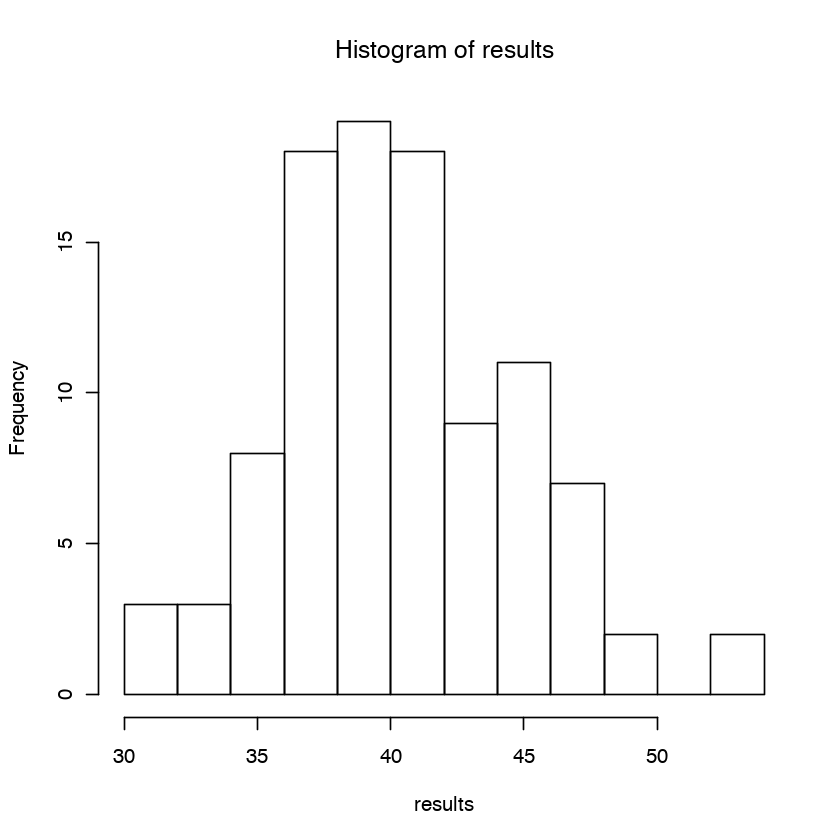

In [145]:
numSims = 100;
results <- c();
for(i in 1:100){
    r <- percentileRelease(data, tperc = 0.4, epsilon = 0.5)$release;
    results <- c(results, r);
}
hist(results)

<hr>

**(d)**<br>

<hr>

## Problem 2: Composition

In [1]:
library("PSIlence")
## PARAMETERS
delta = 10**(-9);
globalEps = 1;

kVals <- seq(from=1, to=100, by=1); #get sequence of values for k
#create
results <- matrix( rep(NA,length(kVals)*3), nrow=length(kVals), ncol=4);

for(i in 1:length(kVals)){
    k = kVals[i];
    #calculate standard deviation for epsilon split based on basic composition
    epsBasic = globalEps / k;
    stdBasic = sqrt(2) / epsBasic;
    #calculate standard deviation for epsilon split based on advanced composition
    epsAdv = globalEps / sqrt(2*k*log(1/delta));
    stdAdv = sqrt(2) / epsAdv;
    
    #calculate standard deviation for epsilon split based on optimal composition
    init <- rep(c(0, 0), k ); 
    params <- matrix(init, nrow=k, ncol=2, byrow=TRUE); #create matrix to feed to update_parameters
    inverse <- PSIlence:::update_parameters(params=params, hold=0, eps=globalEps, del=delta)
    stdOpt = sqrt(2) / inverse[1,1];

    
    results[i, ] <- c(k, stdBasic, stdAdv, stdOpt);
}

Warning message:
“package ‘ggplot2’ was built under R version 3.4.4”

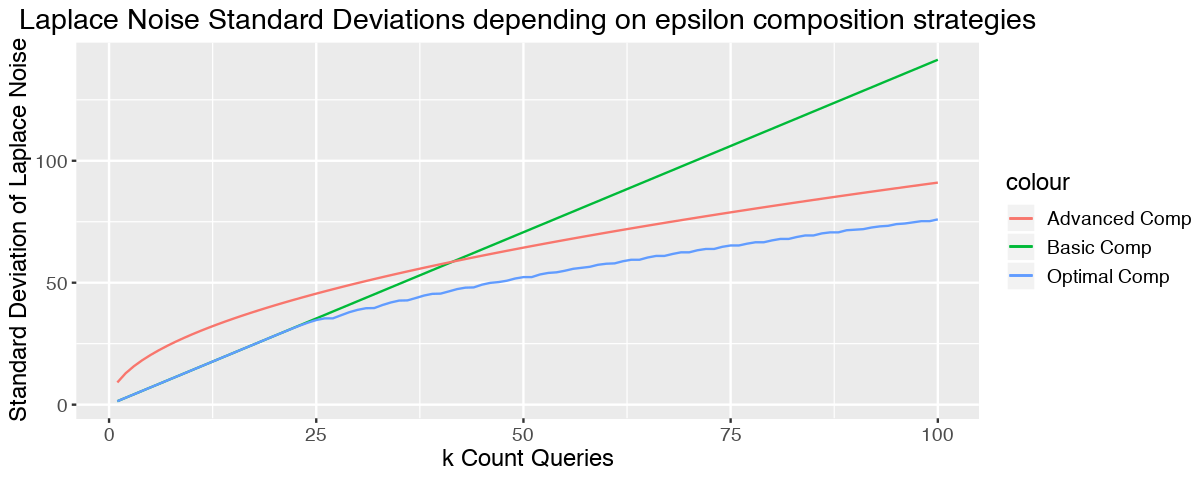

In [2]:
library(ggplot2)
library(grid)

final_results <- as.data.frame(results);
colnames(final_results) <- c("k", "Std_Basic_Comp", "Std_Adv_Comp", "Std_Opt_Comp");
f_size = 16;
fifty = 0.5;
# Plot the standard deviations 
p <- ggplot(data = final_results) + geom_line(aes(x=final_results$k, y=final_results$Std_Basic_Comp, color="Basic Comp")) + geom_line(aes(x=final_results$k, y=final_results$Std_Adv_Comp, color="Advanced Comp")) + geom_line(aes(x=final_results$k, y=final_results$Std_Opt_Comp, color="Optimal Comp")); 

p <- p + labs(title="Laplace Noise Standard Deviations depending on epsilon composition strategies", x="k Count Queries", y = "Standard Deviation of Laplace Noise") + theme(plot.title = element_text(hjust=0.5), text = element_text(size=f_size-2));

options(repr.plot.width=10, repr.plot.height=4); #set plot dimensions
p #show plot

In [10]:
#code for finding the smallest k at which Advanced and Optimal compositions improve upon basic composition
# final_results[final_results$Std_Adv_Comp < final_results$Std_Basic_Comp, ]
# final_results[final_results$Std_Opt_Comp < final_results$Std_Basic_Comp, ]

In the graph above, we can see the expected trends:
1. For basic composition, the standard deviation of the Laplace noise added to each query answer increases linearly with the number of queries. This is because $\epsilon_0$ decrease proportional to $1/k$ so more noise is added with smaller $\epsilon_0$s. <br>
2. Advanced composition adds more noise to the queries for small $k$ than basic composition. However after $k=42$, advanced composition adds less noise than basic composition for higher values of $k$, so each answer has more utility.
<br>
3. Optimal composition does better than advanced composition for every value of $k$. Optimal composition does just as good as basic composition until $k=21$, after which it does much better than basic composition. It is obvious that optimal composition provides the best utility for any value of $k$.

## Problem 3: Synthetic Data

In [2]:
#read in the PUMS dataset
pums_df <- read.csv("../../data/MaPUMS5full.csv");

#trim dataset to 'income','educ','age' columns
pums_df_trimmed <- subset(pums_df, select = c('age', 'educ', 'income') ); 

Warning message in hist(log10(pums_df_trimmed$income)):
“NaNs produced”

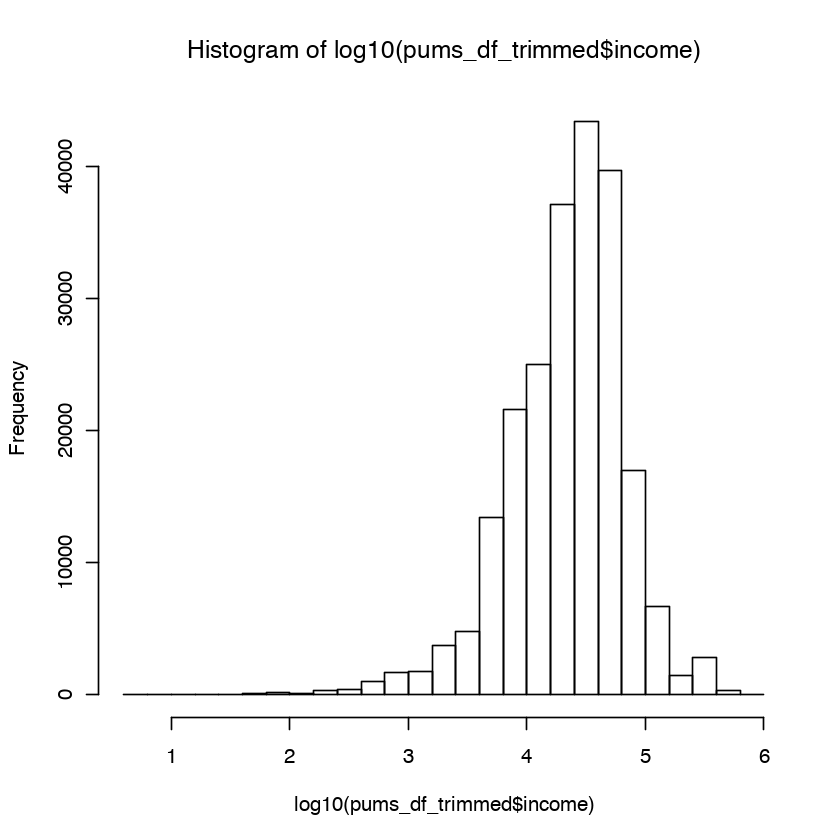

In [8]:
# pums_df_trimmed[0:10, ]
hist(log10(pums_df_trimmed$income))

In [4]:
## Differentially private histogram release for continuous data binned on 3 categories.
## Adapted from J. Honaker's xyHistogramRelease function
xyzHistogramRelease <- function(z, y, x, zlower, zupper, ylower, yupper, xlower, xupper, xnbins=0, ynbins=0, znbins=0, epsilon){
	n <- length(x); #get length of first vector
	if(xnbins==0){
		xlower <- floor(xlower); #floor and ceiling
		xupper <- ceiling(xupper);
		xbins <- xlower:(xupper+1); #generate vector of values to define thresholds for each bin
        xnbins <- length(xbins)-1; #actual number of bins we're using
		xgranularity <- 1; #distance between bins
		xcodebook <- xbins[1:xnbins]; #left thresholds for the bin
    } else {
    	xbins <- seq(from=xlower, to=xupper, length=xnbins+1)
    	xgranularity <- (xupper-xlower)/xnbins
    	xbins[xnbins+1] <-  xbins[xnbins+1] + xgranularity
		xcodebook <- xbins[1:xnbins] + 0.5*xgranularity
    }

	if(ynbins==0){
		ylower <- floor(ylower)
		yupper <- ceiling(yupper)
		ybins <- ylower:(yupper+1); #generate vector of values to define thresholds for each bin      
		ynbins <- length(ybins)-1; #actual number of bins we're using
		ygranularity <- 1; #distance between bins
		ycodebook <- ybins[1:ynbins]; #left thresholds for the bin
    } else {
    	ybins <- seq(from=ylower, to=yupper, length=ynbins+1)
    	ygranularity <- (yupper-ylower)/ynbins
    	ybins[ynbins+1] <-  ybins[ynbins+1] + ygranularity
    	ycodebook <- ybins[1:ynbins] + 0.5*ygranularity
    }
    
    if(znbins==0){
		zlower <- floor(zlower)
		zupper <- ceiling(zupper)
		zbins <- zlower:(zupper+1); #generate vector of values to define thresholds for each bin    
		znbins <- length(zbins)-1; #actual number of bins we're using
		zgranularity <- 1; #distance between bins
		zcodebook <- zbins[1:znbins]; #left thresholds for the bin
    } else {
    	zbins <- seq(from=zlower, to=zupper, length=znbins+1)
    	zgranularity <- (zupper-zlower)/znbins
    	zbins[znbins+1] <-  zbins[znbins+1] + zgranularity
    	zcodebook <- zbins[1:znbins] + 0.5*zgranularity
    }
#     cat('xnbins:',xnbins,'\n ynbins', ynbins, '\n znbins', znbins, '\n');
    #clip x,y,z values
    x.clipped <- clip(x=x, lower=xlower, upper=xupper);
    y.clipped <- clip(x=y, lower=ylower, upper=yupper);
    z.clipped <- clip(x=z, lower=zlower, upper=zupper);

	sensitivity <- 2; #GS is 2 because changing one value changes counts of 2 bins
	scale <- sensitivity / (epsilon);
    #number of rows is the total combinations given by xnbinsn
# 	sensitiveValue <- DPrelease <- matrix(NA, nrow=xnbins*ynbins*znbins, ncol=4);
    DPrelease <- matrix(NA, nrow=xnbins*ynbins*znbins, ncol=5);
    rCounter = 1;
	for(i in 1:xnbins){
		for(j in 1:ynbins){
            for(k in 1:znbins){
                binVal <- sum(x.clipped >= xbins[i] & x.clipped < xbins[i+1] 
                              & y.clipped >= ybins[j] & y.clipped < ybins[j+1] 
                              & z.clipped >= zbins[k] & z.clipped < zbins[k+1]);
#                 sensitiveValue[rCounter, ] <- c(i, j, k, binVal); #save actual count for this bin
                dpAnswer <- binVal + rlap(mu=0, b=scale, size=1); #calculate DP release for this bin
                DPrelease[rCounter, ] <- c(xcodebook[i], ycodebook[j], zcodebook[k], binVal, dpAnswer); #
                rCounter = rCounter + 1; #update the row counter for inputting data into the matrix
            }
        }
	}

# 	return(list(release=DPrelease, true=sensitiveValue, xcodebook=xcodebook, ycodebook=ycodebook, zcodebook=zcodebook))
    return(list(release=DPrelease, xcodebook=xcodebook, ycodebook=ycodebook, zcodebook=zcodebook))
}

I clip *age* from 18 to 100 because the PUMS survey is only taken by adults, so everyone has to be 18 years or older; I chose 100 for the upper bound on *age* arbitrarily, since most individuals should be less than 100 years old. I clip *education* from 1 to 16, since the PUMS codebook specifies these values as the lower and upper bounds for the *education* category.

In [13]:
## FOR TESTING
Sys.time() #for timing

#get DP histogram release for income, education, and age
xyzOut <- xyzHistogramRelease(z=pums_df_trimmed$income, y=pums_df_trimmed$educ, x=pums_df_trimmed$age, zlower=0, zupper=10^6, ylower=1, yupper=16, xlower=18, xupper=100, znbins=20, epsilon=0.5);

Sys.time() #for timing

[1] "2019-03-31 23:40:51 EDT"

[1] "2019-03-31 23:47:14 EDT"

In [6]:
#run simulations for generating synthetic data from DP histogram releases and calculating betas for linear regression coefficients
set.seed(24);
nsims <- 50;
# nsims <- 1;

betahistory <-matrix(NA, nrow=nsims, ncol=3);
Sys.time() #for timing
for(i in 1:nsims){
    message(paste("on simulation ", i));
	xyzOut <- xyzHistogramRelease(z=pums_df_trimmed$income, y=pums_df_trimmed$educ, x=pums_df_trimmed$age, zlower=0, zupper=10^6, ylower=1, yupper=16, xlower=18, xupper=100, znbins=10, epsilon=0.5);

	syn.prob <- as.vector(normalize(xyzOut$release[,5])); #normalize the DP histogram release counts
    #sample row indices from the binned data using calculated probabilities
	syn.x <- sample(x=1:nrow(xyzOut$release), size=nrow(pums_df_trimmed), prob=syn.prob, replace = TRUE);
    synData <- xyzOut$release[syn.x, ]; #generate synthetic data
    synData <- synData[, 1:3]; #we only need the first three columns, which correspond to age, education, income
    print(synData[1:10, ]);
	sampleOutput <- lm(synData[,3] ~ synData[,1] + synData[,2]); #generate linear model from the data
    
    #adding noise drives the correlation values down becausse we have less signal
	betahistory[i,] <- c(sampleOutput$coef[1], sampleOutput$coef[2], sampleOutput$coef[3]);
}
Sys.time() #for timing

#save the betas data from these simulations since it takes awhile to run
goodhistory_df <- as.data.frame(goodhistory);
colnames(goodhistory_df) <- c("beta0", "beta1Age", "beta2Educ");
#save the data
write.csv(goodhistory_df, file='betas_from_DPreleases.csv', row.names=FALSE);


[1] "2019-04-01 07:50:58 EDT"

on simulation  1


      [,1] [,2]  [,3]
 [1,]   19    7 50000
 [2,]   47   13 50000
 [3,]   50   11 50000
 [4,]   40   12 50000
 [5,]   28   10 50000
 [6,]   19    9 50000
 [7,]   67    9 50000
 [8,]   56    9 50000
 [9,]   48   13 50000
[10,]   38    9 50000


on simulation  2


      [,1] [,2]  [,3]
 [1,]   25   13 50000
 [2,]   81    3 50000
 [3,]   60   12 50000
 [4,]   49   10 50000
 [5,]   39    9 50000
 [6,]   30   13 50000
 [7,]   51    9 50000
 [8,]   28   11 50000
 [9,]   50   11 50000
[10,]   83    8 50000


on simulation  3


      [,1] [,2]   [,3]
 [1,]   59   16  50000
 [2,]   38    9  50000
 [3,]   45    9  50000
 [4,]   71   11  50000
 [5,]   29   13  50000
 [6,]   84   13  50000
 [7,]   93    9  50000
 [8,]   20   11  50000
 [9,]   94    6 250000
[10,]   51   11  50000


on simulation  4


      [,1] [,2]   [,3]
 [1,]   35   13  50000
 [2,]   45    9 650000
 [3,]   21    9  50000
 [4,]   59   11  50000
 [5,]   38    2  50000
 [6,]   58   14  50000
 [7,]   34   13 150000
 [8,]   35   12  50000
 [9,]   31   14  50000
[10,]   45   13  50000


on simulation  5


      [,1] [,2]   [,3]
 [1,]   52   11  50000
 [2,]   72    9  50000
 [3,]   50   12  50000
 [4,]   93   13  50000
 [5,]   50   11  50000
 [6,]   58   11  50000
 [7,]   66   12  50000
 [8,]   39   10  50000
 [9,]   89   12 350000
[10,]   42   16 150000


on simulation  6


      [,1] [,2]   [,3]
 [1,]   39   14 750000
 [2,]   75    9  50000
 [3,]   74    9  50000
 [4,]   48    9  50000
 [5,]   40    9  50000
 [6,]   20    9  50000
 [7,]   45    9  50000
 [8,]   65   10  50000
 [9,]   38    9  50000
[10,]   35   13  50000


on simulation  7


      [,1] [,2]   [,3]
 [1,]   47   11  50000
 [2,]   79    3  50000
 [3,]   76    4  50000
 [4,]   92    8 450000
 [5,]   69    1 350000
 [6,]   43   12  50000
 [7,]   39   12  50000
 [8,]   30   13  50000
 [9,]   25    9  50000
[10,]   21   11  50000


on simulation  8


      [,1] [,2]   [,3]
 [1,]   25   12 250000
 [2,]   20    9  50000
 [3,]   57    9  50000
 [4,]   57    9  50000
 [5,]   28   13  50000
 [6,]   25   10 850000
 [7,]   20   11  50000
 [8,]   39   13  50000
 [9,]   59   15  50000
[10,]   98    8 150000


on simulation  9


      [,1] [,2]   [,3]
 [1,]   73    9  50000
 [2,]   51   13  50000
 [3,]   55   15 150000
 [4,]   54   15 250000
 [5,]   34   13  50000
 [6,]   32   16 150000
 [7,]   73    7  50000
 [8,]   18    6  50000
 [9,]   40   16 150000
[10,]   19   10  50000


on simulation  10


      [,1] [,2]   [,3]
 [1,]   31    9  50000
 [2,]   37   14  50000
 [3,]   81    9  50000
 [4,]   36   13  50000
 [5,]   19   10  50000
 [6,]   22   11  50000
 [7,]   35    9  50000
 [8,]   80    9  50000
 [9,]   42    5  50000
[10,]   21    4 950000


on simulation  11


      [,1] [,2]   [,3]
 [1,]   35    9  50000
 [2,]   54   12  50000
 [3,]   41   12  50000
 [4,]   87   15 750000
 [5,]   45   13  50000
 [6,]   33    8  50000
 [7,]   55    9  50000
 [8,]   82    9  50000
 [9,]   72    6 450000
[10,]   67   10  50000


on simulation  12


      [,1] [,2]  [,3]
 [1,]   41   12 50000
 [2,]   47   13 50000
 [3,]   89    9 50000
 [4,]   21    9 50000
 [5,]   53   13 50000
 [6,]   34   13 50000
 [7,]   30   11 50000
 [8,]   31    9 50000
 [9,]   35    9 50000
[10,]   32    9 50000


on simulation  13


      [,1] [,2]   [,3]
 [1,]   22   11  50000
 [2,]   63   10  50000
 [3,]   47   14  50000
 [4,]   19    9 250000
 [5,]   60   14  50000
 [6,]   82   11  50000
 [7,]   61    1 250000
 [8,]   79   10  50000
 [9,]   41    9  50000
[10,]   76    9  50000


on simulation  14


      [,1] [,2]   [,3]
 [1,]   42   13  50000
 [2,]   32    9  50000
 [3,]   39   14 350000
 [4,]   36    9  50000
 [5,]   82    9  50000
 [6,]   49   13  50000
 [7,]   38    9  50000
 [8,]   82    6 250000
 [9,]   23   13  50000
[10,]   49    9  50000


on simulation  15


      [,1] [,2]   [,3]
 [1,]   21   12  50000
 [2,]   41   10  50000
 [3,]   55    8  50000
 [4,]   50   13  50000
 [5,]   32   13  50000
 [6,]   29   15  50000
 [7,]   34   15 350000
 [8,]   58   10  50000
 [9,]   58    9  50000
[10,]   64    7  50000


on simulation  16


      [,1] [,2]   [,3]
 [1,]   70   15 150000
 [2,]   89    4  50000
 [3,]   47    6  50000
 [4,]   48    6 150000
 [5,]   66    3  50000
 [6,]   19    7  50000
 [7,]   72   14 150000
 [8,]   35    9  50000
 [9,]   47   11  50000
[10,]   53   10  50000


on simulation  17


      [,1] [,2]  [,3]
 [1,]   35   13 50000
 [2,]   45   11 50000
 [3,]   41    9 50000
 [4,]   48   12 50000
 [5,]   51   14 50000
 [6,]   79    8 50000
 [7,]   50   13 50000
 [8,]   40    2 50000
 [9,]   52   11 50000
[10,]   30   14 50000


on simulation  18


      [,1] [,2]  [,3]
 [1,]   36    9 50000
 [2,]   47   13 50000
 [3,]   65   12 50000
 [4,]   43    8 50000
 [5,]   36   14 50000
 [6,]   68    9 50000
 [7,]   76    1 50000
 [8,]   20   11 50000
 [9,]   34   13 50000
[10,]   39    9 50000


on simulation  19


      [,1] [,2]   [,3]
 [1,]   41   11  50000
 [2,]   19    9  50000
 [3,]   62    9  50000
 [4,]   48    9  50000
 [5,]   29    9  50000
 [6,]   59   13  50000
 [7,]   45    9  50000
 [8,]   38    9  50000
 [9,]   51   12  50000
[10,]   47   15 750000


on simulation  20


      [,1] [,2]   [,3]
 [1,]   22    9  50000
 [2,]   44   13  50000
 [3,]   35   12  50000
 [4,]   91   13 150000
 [5,]   58    9  50000
 [6,]   25   13  50000
 [7,]   71    9  50000
 [8,]   85    9  50000
 [9,]   49   11 150000
[10,]   32   13  50000


on simulation  21


      [,1] [,2]   [,3]
 [1,]   31    9  50000
 [2,]   52    9  50000
 [3,]   79   14 250000
 [4,]   41   13  50000
 [5,]   75    8  50000
 [6,]   45    9 150000
 [7,]   70   10  50000
 [8,]   56    8  50000
 [9,]   40   12  50000
[10,]   20    1  50000


on simulation  22


      [,1] [,2]   [,3]
 [1,]   76    6  50000
 [2,]   38   14  50000
 [3,]   82   11  50000
 [4,]   32   11 150000
 [5,]   40    7  50000
 [6,]   80    4  50000
 [7,]   78   13 150000
 [8,]   19    6  50000
 [9,]   42    9  50000
[10,]   44   12  50000


on simulation  23


      [,1] [,2]   [,3]
 [1,]   20   11  50000
 [2,]   71    9  50000
 [3,]   46   12  50000
 [4,]   93    1  50000
 [5,]   43    9  50000
 [6,]   46    1  50000
 [7,]   26    9  50000
 [8,]   53   15  50000
 [9,]   90    1 450000
[10,]   35    8  50000


on simulation  24


      [,1] [,2]   [,3]
 [1,]   31   13  50000
 [2,]   69    1  50000
 [3,]   69    6  50000
 [4,]   40   14 350000
 [5,]   37    9  50000
 [6,]   42   13  50000
 [7,]   80   16 150000
 [8,]   19    9  50000
 [9,]   21    9  50000
[10,]   60   14  50000


on simulation  25


      [,1] [,2]   [,3]
 [1,]   59   12 250000
 [2,]   30   13  50000
 [3,]   75    6  50000
 [4,]   75    7  50000
 [5,]   67   15  50000
 [6,]   54   11  50000
 [7,]   41   10 650000
 [8,]   50    8  50000
 [9,]   51    6  50000
[10,]   25   13  50000


on simulation  26


      [,1] [,2]   [,3]
 [1,]   81   11  50000
 [2,]   45   11 150000
 [3,]   34   13  50000
 [4,]   40   11  50000
 [5,]   36   14  50000
 [6,]   54   13  50000
 [7,]   38   13  50000
 [8,]   22   11  50000
 [9,]   56    9  50000
[10,]   37   12  50000


on simulation  27


      [,1] [,2]   [,3]
 [1,]   20   11  50000
 [2,]   37    9  50000
 [3,]   60   11  50000
 [4,]   35   11  50000
 [5,]   23   13  50000
 [6,]   42   13  50000
 [7,]   19   11  50000
 [8,]   41    4  50000
 [9,]   52   14 250000
[10,]   56   12  50000


on simulation  28


      [,1] [,2]   [,3]
 [1,]   82    7  50000
 [2,]   48    9 350000
 [3,]   27   13  50000
 [4,]   40   10  50000
 [5,]   40   15 150000
 [6,]   25    9  50000
 [7,]   49   11  50000
 [8,]   22    9  50000
 [9,]   63    9  50000
[10,]   43   10  50000


on simulation  29


      [,1] [,2]  [,3]
 [1,]   81   13 50000
 [2,]   41    8 50000
 [3,]   20    9 50000
 [4,]   93    9 50000
 [5,]   37   11 50000
 [6,]   28   14 50000
 [7,]   37   10 50000
 [8,]   62   13 50000
 [9,]   35    9 50000
[10,]   49   11 50000


on simulation  30


      [,1] [,2]   [,3]
 [1,]   39    9  50000
 [2,]   45   10  50000
 [3,]   76   11  50000
 [4,]   28    9  50000
 [5,]   58   15  50000
 [6,]   48   13  50000
 [7,]   57   11  50000
 [8,]   64   13  50000
 [9,]   46   16 650000
[10,]   38   15 550000


on simulation  31


      [,1] [,2]   [,3]
 [1,]   52   15  50000
 [2,]   24    6  50000
 [3,]   19   10  50000
 [4,]   52   13  50000
 [5,]   56   13 150000
 [6,]   62   11 350000
 [7,]   33   13  50000
 [8,]   53    7 150000
 [9,]   44    8  50000
[10,]   18   10  50000


on simulation  32


      [,1] [,2]  [,3]
 [1,]   75    9 50000
 [2,]   31   13 50000
 [3,]   50   14 50000
 [4,]   36    9 50000
 [5,]   28   14 50000
 [6,]   18    5 50000
 [7,]   43   13 50000
 [8,]   59   14 50000
 [9,]   36    9 50000
[10,]   84    3 50000


on simulation  33


      [,1] [,2]   [,3]
 [1,]   35   14  50000
 [2,]   78   13  50000
 [3,]   25   13  50000
 [4,]   42    9  50000
 [5,]   38    3  50000
 [6,]   69   13  50000
 [7,]   48   13 150000
 [8,]   65   12  50000
 [9,]   32   12 750000
[10,]   38    9  50000


on simulation  34


      [,1] [,2]   [,3]
 [1,]   53    4  50000
 [2,]   20    9  50000
 [3,]   47   11  50000
 [4,]   53   10  50000
 [5,]   56    9  50000
 [6,]   36   14  50000
 [7,]   63    2 350000
 [8,]   22   13  50000
 [9,]   69    8  50000
[10,]   52   16  50000


on simulation  35


      [,1] [,2]   [,3]
 [1,]   48   14  50000
 [2,]   22   12 350000
 [3,]   53   13  50000
 [4,]   34   15  50000
 [5,]   49    9  50000
 [6,]   48   15 450000
 [7,]   29   12  50000
 [8,]   84   13  50000
 [9,]   43   16 850000
[10,]   49   11  50000


on simulation  36


      [,1] [,2]   [,3]
 [1,]   47   11  50000
 [2,]   87    6 450000
 [3,]   70   13  50000
 [4,]   77    5  50000
 [5,]   28   12 250000
 [6,]   32   14  50000
 [7,]   19    9  50000
 [8,]   75    9  50000
 [9,]   87   10 850000
[10,]   19   11  50000


on simulation  37


      [,1] [,2]  [,3]
 [1,]   50    1 50000
 [2,]   50   11 50000
 [3,]   51   14 50000
 [4,]   27   11 50000
 [5,]   71   12 50000
 [6,]   49   13 50000
 [7,]   68    5 50000
 [8,]   68    6 50000
 [9,]   79   13 50000
[10,]   22    6 50000


on simulation  38


      [,1] [,2]  [,3]
 [1,]   47    9 50000
 [2,]   73    9 50000
 [3,]   65    9 50000
 [4,]   39   13 50000
 [5,]   52   10 50000
 [6,]   20   11 50000
 [7,]   63    7 50000
 [8,]   24   13 50000
 [9,]   50    9 50000
[10,]   57   12 50000


on simulation  39


      [,1] [,2]   [,3]
 [1,]   70    7 150000
 [2,]   21   11  50000
 [3,]   70   13  50000
 [4,]   34   13  50000
 [5,]   83    9  50000
 [6,]   34    9  50000
 [7,]   78    9  50000
 [8,]   22   13  50000
 [9,]   34    9  50000
[10,]   38    9  50000


on simulation  40


      [,1] [,2]   [,3]
 [1,]   18    8  50000
 [2,]   71   10  50000
 [3,]   39   13  50000
 [4,]   25   14  50000
 [5,]   37   13  50000
 [6,]   45    9  50000
 [7,]   60    9  50000
 [8,]   39   15 150000
 [9,]   18    7  50000
[10,]   22    7  50000


on simulation  41


      [,1] [,2]  [,3]
 [1,]   63   11 50000
 [2,]   49    9 50000
 [3,]   77   13 50000
 [4,]   84    6 50000
 [5,]   78    9 50000
 [6,]   47   12 50000
 [7,]   69    9 50000
 [8,]   48   11 50000
 [9,]   29   13 50000
[10,]   37   13 50000


on simulation  42


      [,1] [,2]   [,3]
 [1,]   81    6  50000
 [2,]   88   15 750000
 [3,]   59   13  50000
 [4,]   31   13  50000
 [5,]   89    9  50000
 [6,]   42   10 550000
 [7,]   84    3  50000
 [8,]   23   13  50000
 [9,]   40    9  50000
[10,]   41    8  50000


on simulation  43


      [,1] [,2]  [,3]
 [1,]   20   11 50000
 [2,]   53   13 50000
 [3,]   75    9 50000
 [4,]   45   13 50000
 [5,]   50   11 50000
 [6,]   24    9 50000
 [7,]   36   13 50000
 [8,]   28    9 50000
 [9,]   42   14 50000
[10,]   19    9 50000


on simulation  44


      [,1] [,2]   [,3]
 [1,]   49    4  50000
 [2,]   31    2 750000
 [3,]   20    9  50000
 [4,]   75    9  50000
 [5,]  100    7  50000
 [6,]   27    3 850000
 [7,]   33   11  50000
 [8,]   35   11 550000
 [9,]   30   13  50000
[10,]   69   16 250000


on simulation  45


      [,1] [,2]   [,3]
 [1,]   25    9  50000
 [2,]   49   13  50000
 [3,]   23    8 150000
 [4,]   54   12  50000
 [5,]   38   13  50000
 [6,]   68   13  50000
 [7,]   27    9  50000
 [8,]   76    7  50000
 [9,]   61   13  50000
[10,]   56   13  50000


on simulation  46


      [,1] [,2]   [,3]
 [1,]   31   10  50000
 [2,]   29   14  50000
 [3,]   46   11  50000
 [4,]   24    9  50000
 [5,]   66    9  50000
 [6,]   44   13  50000
 [7,]   28   12  50000
 [8,]   45   13  50000
 [9,]   21   13  50000
[10,]   18   16 250000


on simulation  47


      [,1] [,2]   [,3]
 [1,]   53   11 150000
 [2,]   60    9 150000
 [3,]   57    9  50000
 [4,]   56    6 450000
 [5,]   53    9  50000
 [6,]   38    4 850000
 [7,]   34   13  50000
 [8,]   35    9  50000
 [9,]   44    9  50000
[10,]   29    9  50000


on simulation  48


In [9]:
goodhistory_df

beta0,beta1Age,beta2Educ
82570.42,1225.113,-4033.793


In [38]:
#Calculating regression betas for 100 bootstrapped datasets, so we can calculate a baseline MSE
set.seed(24);
nBootstraps = 100;

bsHistory <-matrix(NA, nrow=nBootstraps, ncol=3);
for(i in 1:nBootstraps){
	#sample row indices for bootstrapped dataset
	bs.x <- sample(x=1:nrow(pums_df_trimmed), size=nrow(pums_df_trimmed), replace = TRUE);
    bootstrappedData <- pums_df_trimmed[bs.x, ]; #get rows for bootstrapped data
    #NEED TO FIX THIS
	print(bootstrappedData[1:3, ])
    bsOutput <- lm(bootstrappedData[,3] ~ bootstrappedData[,1] + bootstrappedData[,2]); #generate linear model from the bootstrapped data
    
    
    #adding noise drives the correlation values down becausse we have less signal
	bsHistory[i,] <- c(bsOutput$coef[1], bsOutput$coef[2], bsOutput$coef[3]);
#     break;
}
bsHistory_df <- as.data.frame(bsHistory);
colnames(bsHistory_df) <- c("beta0", "beta1Age", "beta2Educ");
#save the data so I don't have to run this again
# write.csv(bsHistory_df, file='betas_from_bootstraps.csv', row.names=FALSE);

       age educ income
70754   74   11  28000
54386   51   12  48000
170303  39   13 115900


In [3]:
bootstrappedBetas <- read.csv("./betas_from_bootstraps.csv", header = T);
bootstrappedBetas[1:100, ]
print(var(bootstrappedBetas$beta0));
print(var(bootstrappedBetas$beta1Age));
print(var(bootstrappedBetas$beta2Educ));

beta0,beta1Age,beta2Educ
-29159.11,212.2619,5126.439
-29414.76,210.9873,5149.084
-29322.58,207.3404,5167.199
-29445.32,205.6178,5182.781
-28781.95,201.4338,5137.609
-29964.33,209.2768,5223.746
-29814.34,214.6244,5169.758
-29296.81,205.2314,5170.191
-29192.66,208.1692,5148.012
-29969.34,215.3290,5182.095


[1] 208681.1
[1] 15.82164
[1] 1526.93


In [32]:
##function to calculate the MSE between the true Betas and Betas generated from the synthetic data or bootstrapped data
##
## trueBetas <- vector of the true Betas
## sampledBetas <- dataframe or matrix of Betas, where the i-th column is a list of calculated Betas for the i-th Beta in trueBetas

#####NEED TO FIX
calcMSE <- function(trueBetas, sampledBetas){
    numBetas <- length(trueBetas);
    mseHistory <- matrix(NA, nrow=numBetas, ncol=4);
    for(i in 1:numBetas){
        betaDiffs <- sampledBetas[,i] - trueBetas[i]; #subtract true Beta from calculated Betas
        biasBeta <- mean(betaDiffs); #calculate bias
#         varBeta <- mean(betaDiffs^2); #calculate the variance
        varBeta <- var(sampledBetas[,i]);
        mseBeta <- biasBeta^2 + varBeta; #calculate the MSE
        betaName <- colnames(sampledBetas)[i];
        mseHistory[i, ] <- c(betaName, mseBeta, biasBeta, varBeta);
    }
    
    mseHistory_df <- as.data.frame(mseHistory);
    colnames(mseHistory_df) <- c("Beta", "MSE", "Bias", "Variance");
    return(mseHistory_df);
}

In [33]:
#calculate true betas
pums_df_trimmed_clipped <- pums_df_trimmed; #create copy of pums_df_trimmed
pums_df_trimmed_clipped$age[pums_df_trimmed_clipped$age < 18] <- 18; #lower bound of age is 18
pums_df_trimmed_clipped$age[pums_df_trimmed_clipped$age > 100] <- 100; #upper bound of age is 100
pums_df_trimmed_clipped$income[pums_df_trimmed_clipped$income < 0] <- 0; #lower bound of income is 0
pums_df_trimmed_clipped$income[pums_df_trimmed_clipped$income > 10^6] <- 10^6; #lower bound of income is 1M

true.output <- lm(pums_df_trimmed_clipped$income ~ pums_df_trimmed_clipped$age + pums_df_trimmed_clipped$educ)
true.slope <- coef(true.output);
#save true beta values
trueBeta0 <- true.slope[1];
trueBeta1 <- true.slope[2];
trueBeta2 <- true.slope[3];

trueBetas <- c(trueBeta0, trueBeta1, trueBeta2);
print(trueBetas)

                 (Intercept)  pums_df_trimmed_clipped$age 
                 -29251.7586                     206.9598 
pums_df_trimmed_clipped$educ 
                   5157.2185 


In [34]:
#calculate the MSE, bias, and variance of each Beta
mseDF <- calcMSE(trueBetas = trueBetas, bootstrappedBetas);
mseDF

Beta,MSE,Bias,Variance
beta0,209249.141019287,-23.834392883592,208681.062735158
beta1Age,15.8870732255232,0.255801969533068,15.8216385779062
beta2Educ,1528.16488436953,1.11108977234679,1526.93036388731
